# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

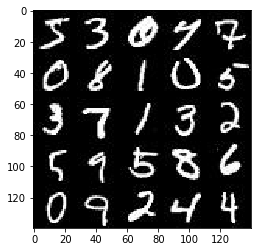

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

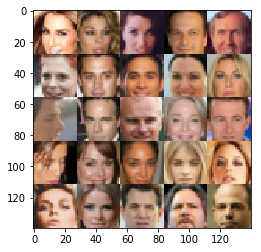

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name='input_real')
    inputs_z = tf.placeholder(tf.float32, shape=[None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # First layer 16x16x64
        layer1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME')
        layer1 = tf.maximum(alpha*layer1, layer1)
        # Second layer 8x8x128
        layer2 = tf.layers.conv2d(layer1, 128, 5, strides=2, padding='SAME')
        layer2 = tf.maximum(alpha*layer2, layer2)
        # Third layer 4x4x256
        layer3 = tf.layers.conv2d(layer2, 256, 5, strides=2, padding='SAME')
        layer3 = tf.maximum(alpha*layer3, layer3)
        
        # Flatten it
        flat = tf.reshape(layer3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        layer1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolution stack 7x7x512
        layer1 = tf.reshape(layer1, (-1, 7, 7, 512))
        layer1 = tf.layers.batch_normalization(layer1, training=is_train)
        layer1 = tf.maximum(alpha*layer1, layer1)
        # Second layer 14x14x256
        layer2 = tf.layers.conv2d_transpose(layer1, 256, 5, strides=2, padding='SAME')
        layer2 = tf.layers.batch_normalization(layer2, training=is_train)
        layer2 = tf.maximum(alpha*layer2, layer2)
        # Third layer 28x28x128
        layer3 = tf.layers.conv2d_transpose(layer2, 128, 5, strides=2, padding='SAME')
        layer3 = tf.layers.batch_normalization(layer3, training=is_train)
        layer3 = tf.maximum(alpha*layer3, layer3)
        
        # Output layer 28x28x5
        logits = tf.layers.conv2d_transpose(layer3, out_channel_dim, 3, strides=1, padding='SAME')
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [31]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 10
    show_every = 100
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                # Normalize input between -1 and 1
                batch_images *= 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval(feed_dict={input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval(feed_dict={input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.3137... Generator Loss: 1.4128
Epoch 1/2... Discriminator Loss: 1.0460... Generator Loss: 0.8827
Epoch 1/2... Discriminator Loss: 1.3714... Generator Loss: 0.4830
Epoch 1/2... Discriminator Loss: 1.2416... Generator Loss: 0.8339
Epoch 1/2... Discriminator Loss: 1.2594... Generator Loss: 0.7971
Epoch 1/2... Discriminator Loss: 1.3863... Generator Loss: 0.6739
Epoch 1/2... Discriminator Loss: 1.4336... Generator Loss: 0.6608
Epoch 1/2... Discriminator Loss: 1.3736... Generator Loss: 0.7025
Epoch 1/2... Discriminator Loss: 1.4264... Generator Loss: 0.6558
Epoch 1/2... Discriminator Loss: 1.3128... Generator Loss: 0.7117


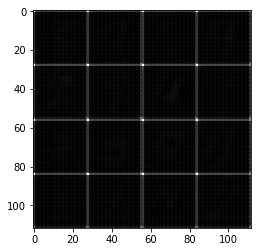

Epoch 1/2... Discriminator Loss: 1.4613... Generator Loss: 0.6146
Epoch 1/2... Discriminator Loss: 1.3963... Generator Loss: 0.6716
Epoch 1/2... Discriminator Loss: 1.3565... Generator Loss: 0.7103
Epoch 1/2... Discriminator Loss: 1.3686... Generator Loss: 0.6573
Epoch 1/2... Discriminator Loss: 1.3525... Generator Loss: 0.6840
Epoch 1/2... Discriminator Loss: 1.3910... Generator Loss: 0.6320
Epoch 1/2... Discriminator Loss: 1.3839... Generator Loss: 0.5902
Epoch 1/2... Discriminator Loss: 1.3479... Generator Loss: 0.6951
Epoch 1/2... Discriminator Loss: 1.2439... Generator Loss: 0.6892
Epoch 1/2... Discriminator Loss: 1.3129... Generator Loss: 0.6947


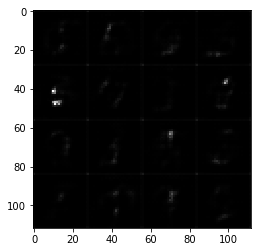

Epoch 1/2... Discriminator Loss: 1.3606... Generator Loss: 0.6863
Epoch 1/2... Discriminator Loss: 1.2981... Generator Loss: 0.7091
Epoch 1/2... Discriminator Loss: 1.3355... Generator Loss: 0.5590
Epoch 1/2... Discriminator Loss: 1.3159... Generator Loss: 0.7253
Epoch 1/2... Discriminator Loss: 1.3230... Generator Loss: 0.8887
Epoch 1/2... Discriminator Loss: 1.2620... Generator Loss: 0.8045
Epoch 1/2... Discriminator Loss: 1.3190... Generator Loss: 0.7464
Epoch 1/2... Discriminator Loss: 1.4095... Generator Loss: 1.2714
Epoch 1/2... Discriminator Loss: 1.3207... Generator Loss: 0.6996
Epoch 1/2... Discriminator Loss: 1.3374... Generator Loss: 0.8441


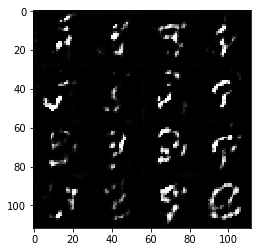

Epoch 1/2... Discriminator Loss: 1.3133... Generator Loss: 0.6755
Epoch 1/2... Discriminator Loss: 1.4749... Generator Loss: 1.2789
Epoch 1/2... Discriminator Loss: 1.3527... Generator Loss: 0.7612
Epoch 1/2... Discriminator Loss: 1.3720... Generator Loss: 0.6716
Epoch 1/2... Discriminator Loss: 1.3246... Generator Loss: 0.7241
Epoch 1/2... Discriminator Loss: 1.3360... Generator Loss: 0.7206
Epoch 1/2... Discriminator Loss: 1.2378... Generator Loss: 0.8161
Epoch 1/2... Discriminator Loss: 1.2683... Generator Loss: 0.7785
Epoch 1/2... Discriminator Loss: 1.4011... Generator Loss: 0.5904
Epoch 1/2... Discriminator Loss: 1.3813... Generator Loss: 0.6679


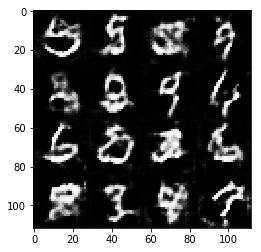

Epoch 1/2... Discriminator Loss: 1.3792... Generator Loss: 0.6444
Epoch 1/2... Discriminator Loss: 1.2977... Generator Loss: 0.6486
Epoch 1/2... Discriminator Loss: 1.3675... Generator Loss: 0.7905
Epoch 1/2... Discriminator Loss: 1.3829... Generator Loss: 0.6349
Epoch 1/2... Discriminator Loss: 1.3405... Generator Loss: 0.7275
Epoch 1/2... Discriminator Loss: 1.4367... Generator Loss: 0.6238
Epoch 2/2... Discriminator Loss: 1.3818... Generator Loss: 0.7204
Epoch 2/2... Discriminator Loss: 1.3405... Generator Loss: 0.6589
Epoch 2/2... Discriminator Loss: 1.3959... Generator Loss: 0.5753
Epoch 2/2... Discriminator Loss: 1.3561... Generator Loss: 0.6966


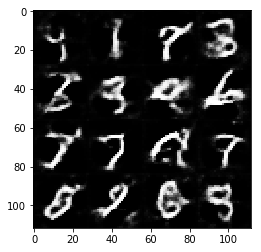

Epoch 2/2... Discriminator Loss: 1.2593... Generator Loss: 0.7681
Epoch 2/2... Discriminator Loss: 1.3704... Generator Loss: 0.5862
Epoch 2/2... Discriminator Loss: 1.3445... Generator Loss: 0.7016
Epoch 2/2... Discriminator Loss: 1.3230... Generator Loss: 0.6241
Epoch 2/2... Discriminator Loss: 1.3759... Generator Loss: 0.6521
Epoch 2/2... Discriminator Loss: 1.3540... Generator Loss: 0.7374
Epoch 2/2... Discriminator Loss: 1.3547... Generator Loss: 0.6620
Epoch 2/2... Discriminator Loss: 1.3604... Generator Loss: 0.8974
Epoch 2/2... Discriminator Loss: 1.3440... Generator Loss: 0.6423
Epoch 2/2... Discriminator Loss: 1.3563... Generator Loss: 0.6704


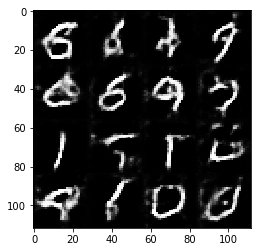

Epoch 2/2... Discriminator Loss: 1.3396... Generator Loss: 0.6867
Epoch 2/2... Discriminator Loss: 1.3387... Generator Loss: 0.6130
Epoch 2/2... Discriminator Loss: 1.4704... Generator Loss: 0.4191
Epoch 2/2... Discriminator Loss: 1.3863... Generator Loss: 0.5822
Epoch 2/2... Discriminator Loss: 1.3394... Generator Loss: 0.6240
Epoch 2/2... Discriminator Loss: 1.4686... Generator Loss: 0.4532
Epoch 2/2... Discriminator Loss: 1.3331... Generator Loss: 0.7729
Epoch 2/2... Discriminator Loss: 1.3725... Generator Loss: 0.7397
Epoch 2/2... Discriminator Loss: 1.3375... Generator Loss: 0.8207
Epoch 2/2... Discriminator Loss: 1.3386... Generator Loss: 0.8644


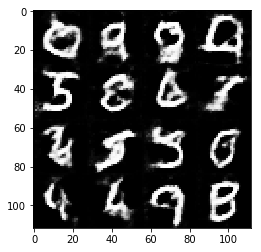

Epoch 2/2... Discriminator Loss: 1.3430... Generator Loss: 0.6003
Epoch 2/2... Discriminator Loss: 1.3450... Generator Loss: 0.8497
Epoch 2/2... Discriminator Loss: 1.3473... Generator Loss: 0.6668
Epoch 2/2... Discriminator Loss: 1.3289... Generator Loss: 0.7809
Epoch 2/2... Discriminator Loss: 1.3498... Generator Loss: 0.8277
Epoch 2/2... Discriminator Loss: 1.3300... Generator Loss: 0.7419
Epoch 2/2... Discriminator Loss: 1.3046... Generator Loss: 0.6748
Epoch 2/2... Discriminator Loss: 1.3592... Generator Loss: 0.7014
Epoch 2/2... Discriminator Loss: 1.3455... Generator Loss: 0.6427
Epoch 2/2... Discriminator Loss: 1.3345... Generator Loss: 0.6545


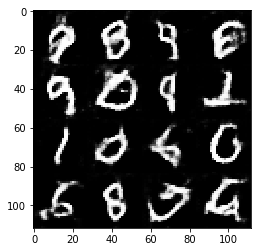

Epoch 2/2... Discriminator Loss: 1.3335... Generator Loss: 0.6896
Epoch 2/2... Discriminator Loss: 1.3886... Generator Loss: 0.8705
Epoch 2/2... Discriminator Loss: 1.3382... Generator Loss: 0.7244
Epoch 2/2... Discriminator Loss: 1.3826... Generator Loss: 0.6740
Epoch 2/2... Discriminator Loss: 1.3286... Generator Loss: 0.6757
Epoch 2/2... Discriminator Loss: 1.3660... Generator Loss: 0.6242
Epoch 2/2... Discriminator Loss: 1.3465... Generator Loss: 0.6161
Epoch 2/2... Discriminator Loss: 1.4104... Generator Loss: 1.0894
Epoch 2/2... Discriminator Loss: 1.2851... Generator Loss: 0.6912
Epoch 2/2... Discriminator Loss: 1.3130... Generator Loss: 0.7582


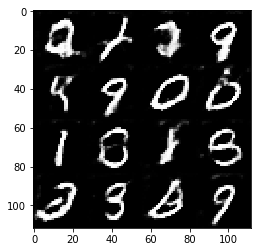

Epoch 2/2... Discriminator Loss: 1.3618... Generator Loss: 0.6198
Epoch 2/2... Discriminator Loss: 1.3246... Generator Loss: 0.7064
Epoch 2/2... Discriminator Loss: 1.3604... Generator Loss: 0.6000


In [32]:
batch_size = 128
z_dim = 100
learning_rate = 0.0003
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.1661... Generator Loss: 3.2628
Epoch 1/1... Discriminator Loss: 0.2770... Generator Loss: 2.1233
Epoch 1/1... Discriminator Loss: 0.7738... Generator Loss: 1.4160
Epoch 1/1... Discriminator Loss: 0.5290... Generator Loss: 3.1048
Epoch 1/1... Discriminator Loss: 1.0449... Generator Loss: 1.8253
Epoch 1/1... Discriminator Loss: 1.0377... Generator Loss: 2.0043
Epoch 1/1... Discriminator Loss: 1.1806... Generator Loss: 1.7410
Epoch 1/1... Discriminator Loss: 1.1513... Generator Loss: 1.5919
Epoch 1/1... Discriminator Loss: 1.1178... Generator Loss: 0.8252
Epoch 1/1... Discriminator Loss: 1.1731... Generator Loss: 0.9024


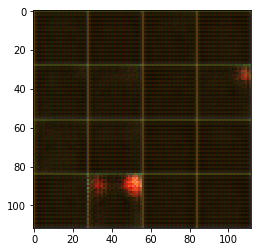

Epoch 1/1... Discriminator Loss: 1.2558... Generator Loss: 0.9142
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.7459
Epoch 1/1... Discriminator Loss: 1.3107... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.6269
Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 0.6129
Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.6348
Epoch 1/1... Discriminator Loss: 1.3426... Generator Loss: 0.6363
Epoch 1/1... Discriminator Loss: 1.3272... Generator Loss: 0.6098
Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 0.6199
Epoch 1/1... Discriminator Loss: 1.2916... Generator Loss: 0.7071


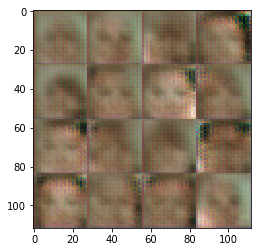

Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.5651
Epoch 1/1... Discriminator Loss: 1.2942... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.6227
Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 0.7070
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.7699
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.5732
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.8041
Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 0.7237


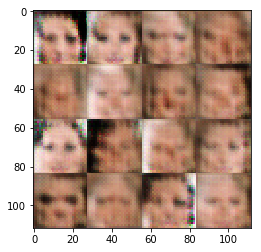

Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.7343
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.5902
Epoch 1/1... Discriminator Loss: 1.3737... Generator Loss: 0.7001
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.6458
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.6798
Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 1.3366... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.7290
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.7364


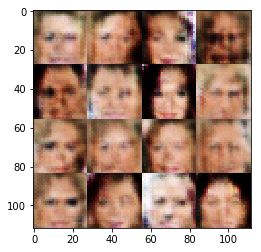

Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.6320
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.6214
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.7350
Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.6775
Epoch 1/1... Discriminator Loss: 1.3078... Generator Loss: 0.7050
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.6684


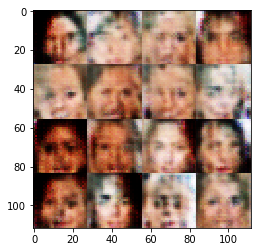

Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.6706
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.7143
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.7413
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.7361
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.7193
Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 0.8139
Epoch 1/1... Discriminator Loss: 1.3031... Generator Loss: 0.8130
Epoch 1/1... Discriminator Loss: 1.1856... Generator Loss: 0.9711
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.6655
Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 0.7220


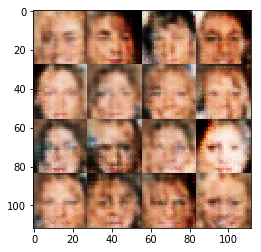

Epoch 1/1... Discriminator Loss: 1.3555... Generator Loss: 0.8324
Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.6853
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.6422
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6936
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.5184
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.7241
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 1.2331... Generator Loss: 1.2710
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.6745


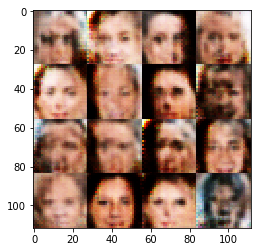

Epoch 1/1... Discriminator Loss: 1.4567... Generator Loss: 0.5037
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.7138
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.7094
Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 1.2706... Generator Loss: 0.8995
Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 0.7308
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6112


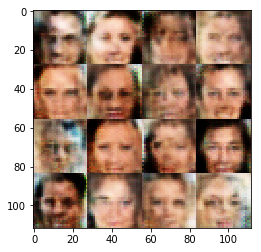

Epoch 1/1... Discriminator Loss: 1.3253... Generator Loss: 0.7359
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.6858
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.5794
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.6870
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 1.2671... Generator Loss: 0.9527
Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 0.7852
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.6058


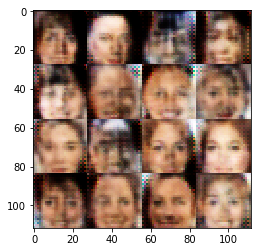

Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.5944
Epoch 1/1... Discriminator Loss: 1.2964... Generator Loss: 0.8198
Epoch 1/1... Discriminator Loss: 1.3570... Generator Loss: 0.6989
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.5241
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.6890
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.3372... Generator Loss: 0.8386
Epoch 1/1... Discriminator Loss: 1.3474... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.5958
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.7254


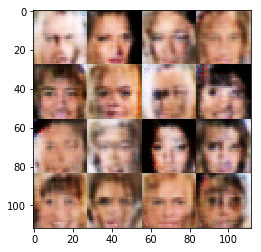

Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.5948
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.2553... Generator Loss: 1.2672
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.6840
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.7317
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.7031
Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 0.8237
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.6714
Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 0.6926


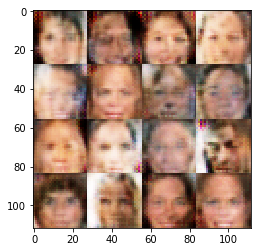

Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.6256
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.8486
Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 0.6400
Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.6847
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.6847
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.6886
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.6871
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.6990


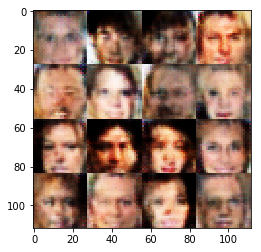

Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.7131
Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.6987
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.6968
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.7226
Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.6577
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.6757


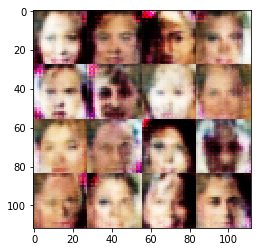

Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.6413
Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 0.8430
Epoch 1/1... Discriminator Loss: 1.3503... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 0.6907
Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 0.7539
Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.6503
Epoch 1/1... Discriminator Loss: 1.3385... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.6756
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.3424... Generator Loss: 0.7729


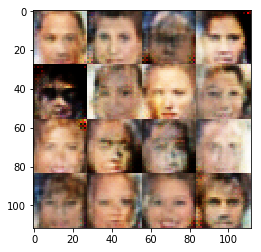

Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.6621
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.7067
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.7031
Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.6934
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.5684
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.6821


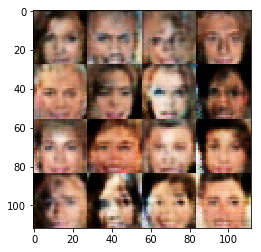

Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.7094
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 1.3833... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.6889
Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.7085
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.6806
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.7015


In [33]:
batch_size = 128
z_dim = 100
learning_rate = 0.0003
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.